# Building a Chatbot with LangGraph: A Comprehensive Guide

This guide walks you through building a chatbot using LangGraph, LangChain, and Large Language Models (LLMs). Each section blends theory with practical code examples.


# Introduction to Large Language Models (LLMs)

## What is an LLM?
Large Language Models (LLMs) are advanced machine learning models that excel in a wide range of language-related tasks such as text generation, translation, summarization, question answering, and more, without needing task-specific fine tuning for every scenario.

Modern LLMs are typically accessed through a **chat model interface** that takes **a list of messages** as input and returns **a message** as output.


The newest generation of chat models offer additional capabilities:

 - **Tool calling**: Many popular chat models offer a native tool calling API. This API allows developers to build rich applications that enable LLMs to interact with external services, APIs, and databases. Tool calling can also be used to extract structured information from unstructured data and perform various other tasks.
 - **Structured output**: A technique to make a chat model respond in a structured format, such as JSON that matches a given schema.
 - **Multimodality**: The ability to work with data other than text; for example, images, audio, and video.


## Why LLMs?
LLMs make it easy to embed intelligence into a new application.



# Introduction to LangChain Ecosystem

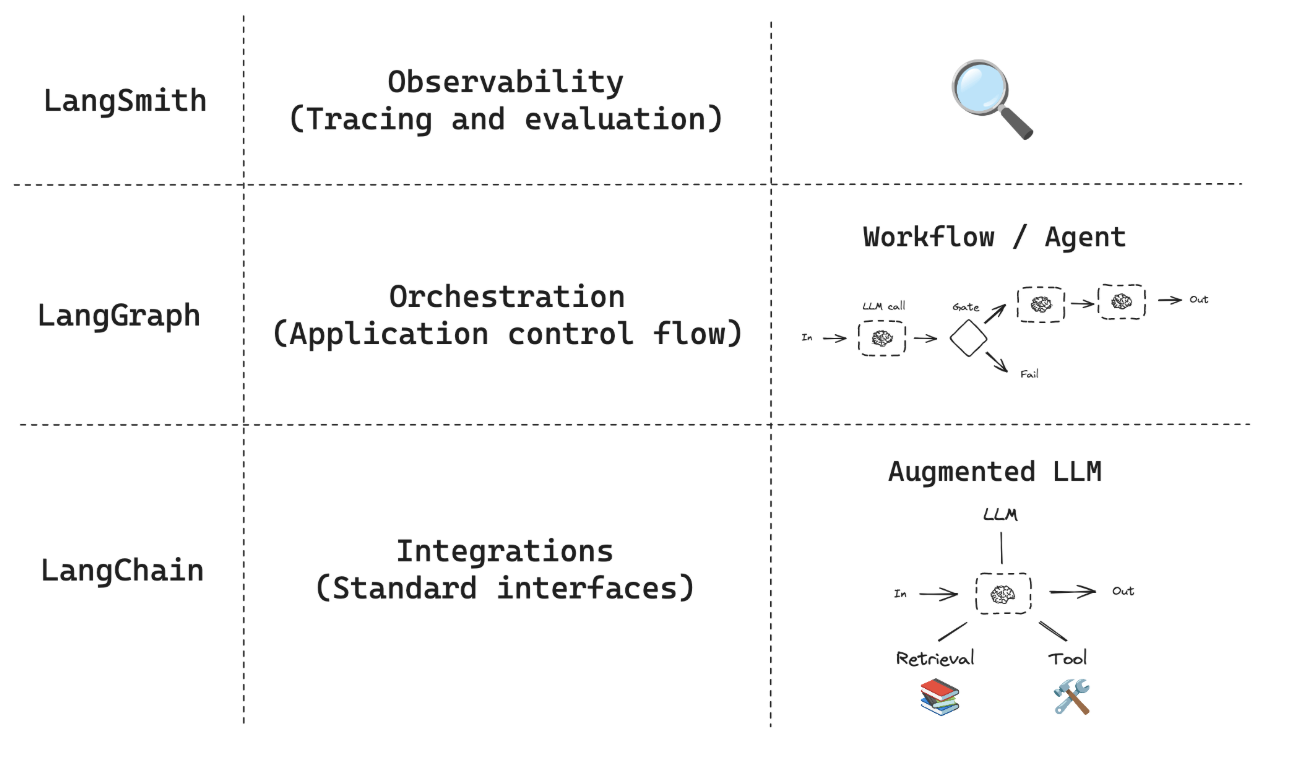

# What is LangChain?
LangChain implements a standard interface for large language models and related technologies, such as embedding models and vector stores, and integrates with hundreds of providers.

## Using Chat Models with LangChain
LangChain provides a standardized interface for chat models, making it easy to access many different providers.

In [5]:
from dotenv import load_dotenv
load_dotenv()

from langchain.chat_models import init_chat_model


openai_llm = init_chat_model("openai:gpt-4o-mini", temperature=0)

google_llm = init_chat_model("google_genai:gemini-2.0-flash", temperature=0)

## Running the model
The init_chat_model interface provides standardized methods for using chat models, which include:

 - invoke(): A single input is transformed into an output.
 - stream(): Outputs are streamed as they are produced.

In [6]:
response = google_llm.invoke("Hello, how are you?")
response

AIMessage(content="I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f5291407-6602-44ca-a559-22cc44181ea5-0', usage_metadata={'input_tokens': 6, 'output_tokens': 50, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})

In [7]:
type(response)

langchain_core.messages.ai.AIMessage

In [8]:
from rich.markdown import Markdown

Markdown(response.content)

I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the   
same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?

In [9]:
response = openai_llm.stream("write a paragraph about AI")

for chunk in response:
    print(chunk.content, end="")
    


Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, particularly computer systems. It encompasses a range of technologies, including machine learning, natural language processing, and robotics, enabling machines to perform tasks that typically require human intelligence, such as understanding language, recognizing patterns, and making decisions. AI has transformed various industries, from healthcare, where it aids in diagnostics and personalized medicine, to finance, where it enhances fraud detection and risk assessment. As AI continues to evolve, it raises important ethical considerations regarding privacy, bias, and the future of work, prompting ongoing discussions about how to harness its potential responsibly while ensuring it benefits society as a whole.

## What is LangGraph?
LangGraph provides low-level supporting infrastructure that sits underneath any workflow or agent.

It does not abstract prompts or architecture, and provides a few benefits:

- Control: Make it easy to define and / or combine agents and workflows.
- Persistence: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- Testing, Debugging, and Deployment: Provide an easy onramp for testing, debugging, and deploying applications.

## Control
LangGraph lets you define your application as a graph with:

- State: What information do we need to track over the course of the application?
- Nodes: How do we want to update this information over the course of the application?
- Edges: How do we want to connect these nodes together?

We can use the **StateGraph** class to initialize a LangGraph graph with a State object.

State defines the schema for information we want to track over the course of the application.

## The simplest graph

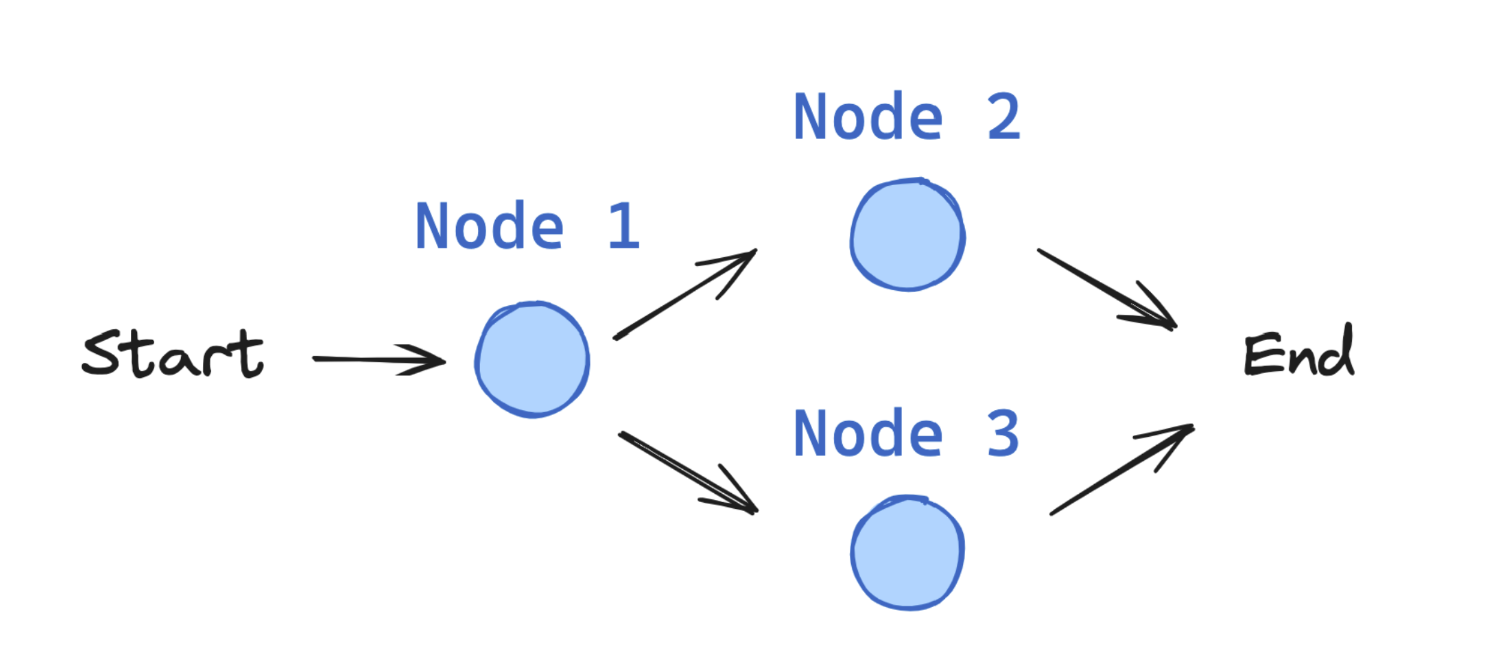

## State
First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.

In [10]:
from typing import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes
Nodes are just python functions.

The first positional argument is the state, as defined above.

Because the state is a TypedDict with schema as defined above, each node can access the key, graph_state, with state['graph_state'].

Each node returns a new value of the state key graph_state.

By default, the new value returned by each node will override the prior state value.

In [11]:
def node_1(state: State)->State:
    print("Node 1")
    
    
    #get the current state
    state = state["graph_state"]
    
    #Add new information to the state
    new_information = "Information from node 1"
    
    #updated state
    updated_state = state + new_information
    
    return {"graph_state": updated_state}


def node_2(state: State)->State:
    print("Node 2")
    
    #get the current state
    state = state["graph_state"]
    
    #Add new information to the state
    new_information = "Information from node 2"
    
    #updated state
    updated_state = state + new_information
    
    return {"graph_state": updated_state}


def node_3(state: State)->State:
    print("Node 3")
    
    #get the current state
    state = state["graph_state"]
    
    #Add new information to the state
    new_information = "Information from node 3"
    
    #updated state
    updated_state = state + new_information
    
    return {"graph_state": updated_state}

## Edges
Edges connect the nodes.

Normal Edges are used if you want to always go from, for example, node_1 to node_2.

Conditional Edges are used if you want to optionally route between nodes.

Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [12]:
from typing import Literal
import random

def router(state: State)->Literal["node_2", "node_3"]:
    
    #get the current state
    state = state["graph_state"]
    
    ## Use the state to decide on the next node to visit
    
    # Lets just use random for now
    if random.random() < 0.5:
        next_node = "node_2"
    else:
        next_node = "node_3"

    return next_node
    

## Graph Construction
Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a Mermaid diagram.

In [13]:
from langgraph.graph import StateGraph, START, END
#Build the graph
graph_builder = StateGraph(State)

#Add nodes
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

#Add edges
graph_builder.add_edge(START, "node_1")
graph_builder.add_conditional_edges("node_1", router)
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)

#Compile the graph
graph = graph_builder.compile()


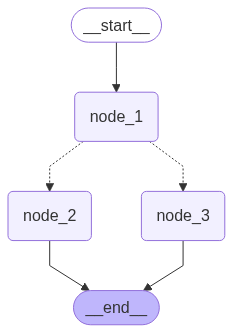

In [14]:
#View the graph
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


## Graph Invocation
The compiled graph implements the runnable protocol.

This provides a standard way to execute LangChain components.

invoke is one of the standard methods in this interface.

The input is a dictionary {"graph_state": "Hi, this is lance."}, which sets the initial value for our graph state dict.

When invoke is called, the graph starts execution from the START node.

It progresses through the defined nodes (node_1, node_2, node_3) in order.

The conditional edge will traverse from node 1 to node 2 or 3 using a 50/50 decision rule.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the END node.

In [15]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

Node 1
Node 3


{'graph_state': 'Hi, this is Lance.Information from node 1Information from node 3'}